In [1]:
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

data_path = 'day051/'
df_train = pd.read_csv(data_path + 'train_data.csv')
df_test = pd.read_csv(data_path + 'test_features.csv')

df_train

,name,bonus,deferral_payments,deferred_income,director_fees,email_address,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,...,long_term_incentive,other,poi,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,RICE KENNETH D,1750000.0,NaN,-3504386.0,NaN,ken.rice@enron.com,19794175.0,46950.0,18.0,42.0,...,1617011.0,174839.0,True,2748364.0,NaN,420636.0,864.0,905.0,505050.0,22542539.0
1,SKILLING JEFFREY K,5600000.0,NaN,NaN,NaN,jeff.skilling@enron.com,19250000.0,29336.0,108.0,88.0,...,1920000.0,22122.0,True,6843672.0,NaN,1111258.0,2042.0,3627.0,8682716.0,26093672.0
2,SHELBY REX,200000.0,NaN,-4167.0,NaN,rex.shelby@enron.com,1624396.0,22884.0,39.0,13.0,...,NaN,1573324.0,True,869220.0,NaN,211844.0,91.0,225.0,2003885.0,2493616.0
3,KOPPER MICHAEL J,800000.0,NaN,NaN,NaN,michael.kopper@enron.com,NaN,118134.0,NaN,NaN,...,602671.0,907502.0,True,985032.0,NaN,224305.0,NaN,NaN,2652612.0,985032.0
4,CALGER CHRISTOPHER F,1250000.0,NaN,-262500.0,NaN,christopher.calger@enron.com,NaN,35818.0,144.0,199.0,...,375304.0,486.0,True,126027.0,NaN,240189.0,2188.0,2598.0,1639297.0,126027.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,STABLER FRANK,500000.0,NaN,NaN,NaN,frank.stabler@enron.com,NaN,16514.0,NaN,NaN,...,NaN,356071.0,False,511734.0,NaN,239502.0,NaN,NaN,1112087.0,511734.0
109,BROWN MICHAEL,NaN,NaN,NaN,NaN,michael.brown@enron.com,NaN,49288.0,41.0,13.0,...,NaN,NaN,False,NaN,NaN,NaN,761.0,1486.0,49288.0,NaN
110,PICKERING MARK R,300000.0,NaN,NaN,NaN,mark.pickering@enron.com,28798.0,31653.0,67.0,7.0,...,NaN,NaN,False,NaN,NaN,655037.0,728.0,898.0,1386690.0,28798.0
111,HAUG DAVID L,NaN,NaN,NaN,NaN,david.haug@enron.com,NaN,475.0,19.0,4.0,...,NaN,NaN,False,2217299.0,NaN,NaN,471.0,573.0,475.0,2217299.0


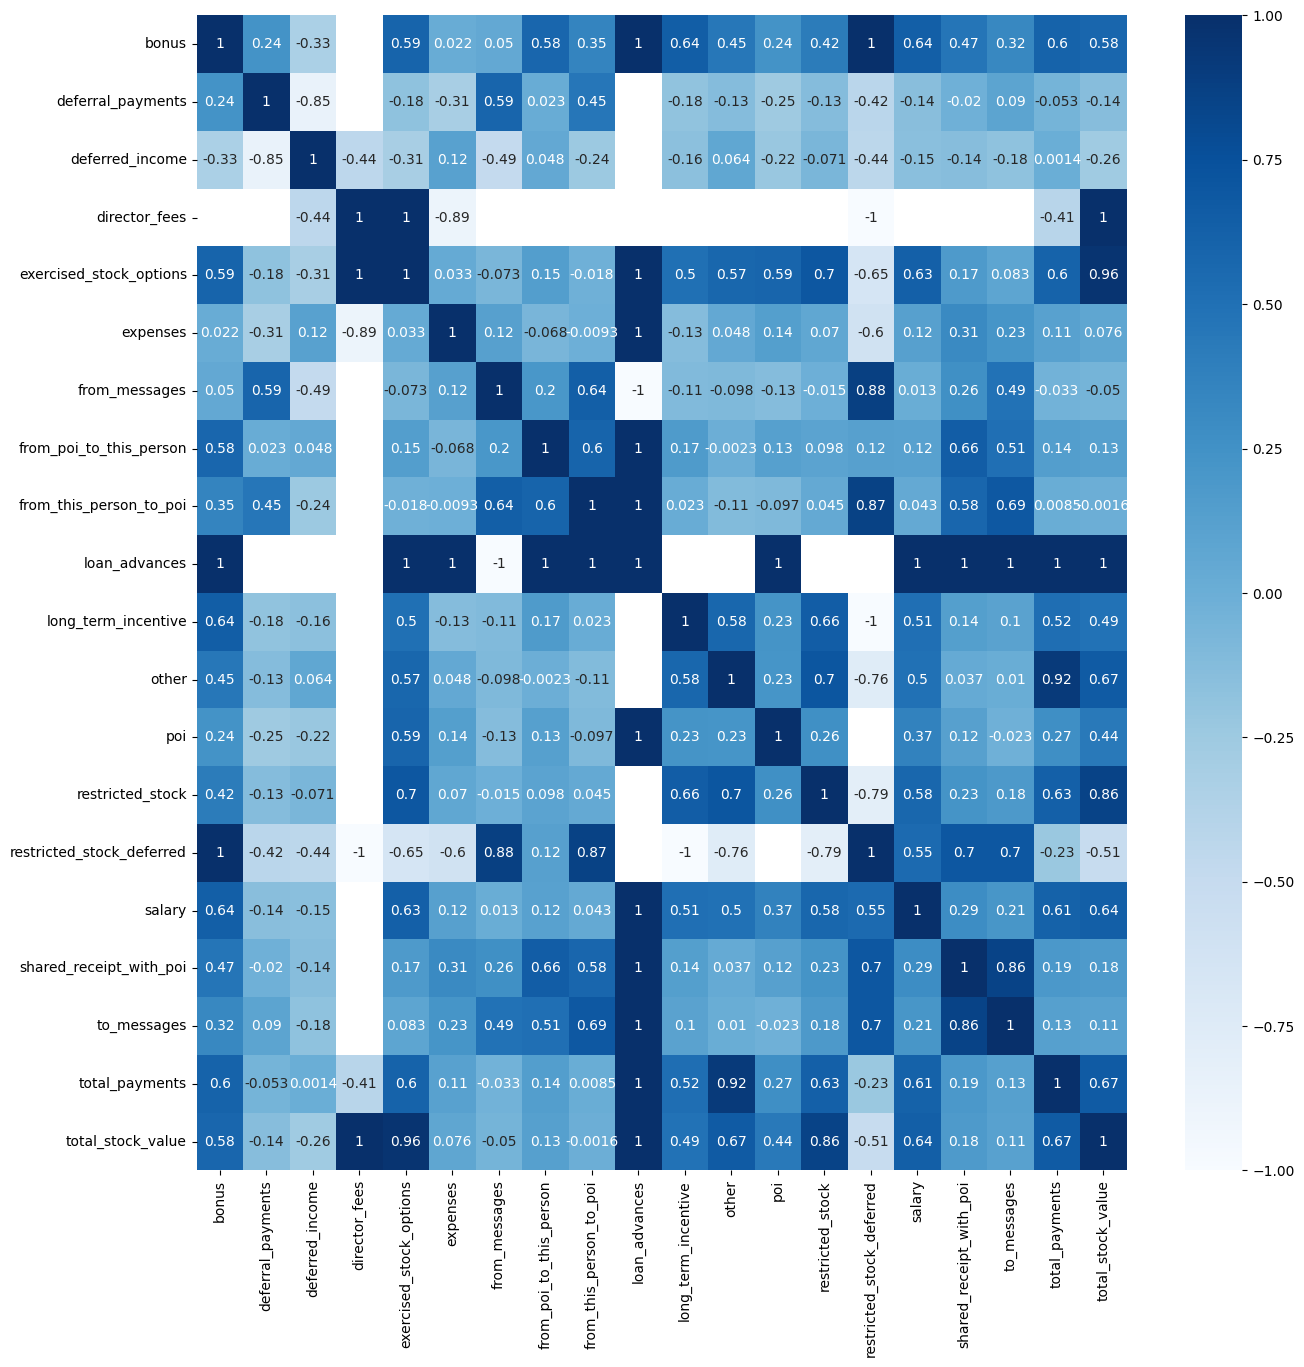

In [2]:
# 計算df整體相關係數, 並繪製成熱圖
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_train.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, center=0, cmap='Blues', vmin=-1, vmax=1, annot=True, ax=ax)
plt.show()

In [3]:
train_Y = df_train['poi']
ids = df_test['name']
df_train = df_train.drop(['name', 'poi', 'email_address'] , axis=1)
df_test = df_test.drop(['name', 'email_address'] , axis=1)
df = pd.concat([df_train, df_test])

- 總結一下這個項目的目標以及機器學習如何有助於實現它。作為答案的一部分，提供有關數據集的一些背景知識以及如何使用它來回答項目問題。當你得到它時，數據中是否有任何異常值，你是如何處理這些異常值的？ [關鍵字：“EDA”，“Outlier”]


In [4]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data)
na_check(df)

,Missing Ratio
loan_advances,97.260274
director_fees,88.356164
restricted_stock_deferred,87.671233
deferral_payments,73.287671
deferred_income,66.438356
long_term_incentive,54.794521
bonus,43.835616
from_poi_to_this_person,41.095890
from_this_person_to_poi,41.095890
from_messages,41.095890


In [5]:
# bonus : 用 log 去偏態, 0 則直接取 0
df["bonus"] = df["bonus"].map(lambda i: np.log(i) if i > 0 else 0)

# 有關 email 數量的特徵: ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 
#       'shared_receipt_with_poi'] : 缺值用中位數補
df["to_messages"] = df["to_messages"].fillna(df['to_messages'].median())
df["from_poi_to_this_person"] = df["from_poi_to_this_person"].fillna(df['from_poi_to_this_person'].median())
df["from_messages"] = df["from_messages"].fillna(df['from_messages'].median())
df["from_this_person_to_poi"] = df["from_this_person_to_poi"].fillna(df['from_this_person_to_poi'].median())
df["shared_receipt_with_poi"] = df["shared_receipt_with_poi"].fillna(df['shared_receipt_with_poi'].median())

# 'salary', 'deferral_payments', 'total_payments', 'expenses', 'other', 'long_term_incentive': 缺值用中位數補
df["salary"] = df["salary"].fillna(df['salary'].median())
df["deferral_payments"] = df["deferral_payments"].fillna(df['deferral_payments'].median())
df["total_payments"] = df["total_payments"].fillna(df['total_payments'].median())
df["expenses"] = df["expenses"].fillna(df['expenses'].median())
df["other"] = df["other"].fillna(df['other'].median())
df["long_term_incentive"] = df["long_term_incentive"].fillna(df['long_term_incentive'].median())

# stock: ['restricted_stock_deferred', 'exercised_stock_options', 'restricted_stock', 'total_stock_value'] : 
#    用 log 去偏態, 0 則直接取 0
df["restricted_stock"] = df["restricted_stock"].map(lambda i: np.log(i) if i > 0 else 0)
df["restricted_stock_deferred"] = df["restricted_stock_deferred"].map(lambda i: np.log(i) if i > 0 else 0)
df["exercised_stock_options"] = df["exercised_stock_options"].map(lambda i: np.log(i) if i > 0 else 0)
df["total_stock_value"] = df["total_stock_value"].map(lambda i: np.log(i) if i > 0 else 0)

df["director_fees"] = df["director_fees"].map(lambda i: np.log(i) if i > 0 else 0)
df["deferred_income"] = df["deferred_income"].map(lambda i: np.log(i) if i > 0 else 0)
df["loan_advances"] = df["loan_advances"].fillna(df['loan_advances'].median())

In [6]:
na_check(df)
df

,Missing Ratio


,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,14.375126,227449.0,0,0.0,16.800898,46950.0,18.0,42.0,4.0,41762500.0,1617011.0,174839.0,14.826516,0.0,420636.0,864.0,905.0,505050.0,16.930915
1,15.538277,227449.0,0,0.0,16.773022,29336.0,108.0,88.0,30.0,41762500.0,1920000.0,22122.0,15.738835,0.0,1111258.0,2042.0,3627.0,8682716.0,17.077203
2,12.206073,227449.0,0,0.0,14.300647,22884.0,39.0,13.0,14.0,41762500.0,442035.0,1573324.0,13.675352,0.0,211844.0,91.0,225.0,2003885.0,14.729244
3,13.592367,227449.0,0,0.0,0.000000,118134.0,41.0,35.0,8.0,41762500.0,602671.0,907502.0,13.800429,0.0,224305.0,740.5,1211.0,2652612.0,13.800429
4,14.038654,227449.0,0,0.0,0.000000,35818.0,144.0,199.0,25.0,41762500.0,375304.0,486.0,11.744251,0.0,240189.0,2188.0,2598.0,1639297.0,11.744251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,13.815511,227449.0,0,0.0,14.197867,38559.0,40.0,23.0,8.0,41762500.0,369721.0,425688.0,12.842866,0.0,213625.0,1336.0,1607.0,2047593.0,14.427348
29,14.220976,227449.0,0,0.0,14.422859,46950.0,92.0,28.0,23.0,41762500.0,554422.0,1852186.0,14.072804,0.0,428780.0,2103.0,3187.0,4335388.0,14.956218
30,0.000000,504610.0,0,0.0,14.612240,46950.0,12.0,0.0,0.0,41762500.0,461912.0,52382.0,0.000000,0.0,259996.0,23.0,169.0,966522.0,14.612240
31,12.206073,204075.0,0,0.0,14.751353,57727.0,41.0,35.0,8.0,41762500.0,175000.0,2630.0,13.151625,0.0,236457.0,740.5,1211.0,875889.0,14.935300


- 您最終在 POI 的偵測中使用了哪些特徵 (features)，以及您使用哪些方法來選擇它們？

In [7]:
high_list = list(corr[(corr['poi']>0.3) | (corr['poi']<-0.3)].index)
high_list.pop(high_list.index('poi'))
high_list

['exercised_stock_options', 'loan_advances', 'salary', 'total_stock_value']

In [8]:
# 將資料最大最小化
MMEncoder = MinMaxScaler()

df_mm = MMEncoder.fit_transform(df)

# 將前述轉換完畢資料 df , 重新切成 train_X, test_X
train_num = train_Y.shape[0]
train_X = df_mm[:train_num]
test_X = df_mm[train_num:]

In [9]:
lr = LogisticRegression()
lr.fit(train_X, train_Y)
lr_pred = lr.predict_proba(test_X)[:,1]
sub = pd.DataFrame({'name': ids, 'poi': lr_pred})
sub.to_csv('midterm_lr.csv', index=False) 

In [10]:
# # 原始特徵 + 邏輯斯迴歸
# estimator = LogisticRegression()
# cross_val_score(estimator, train_X, train_Y, cv=5).mean()

In [11]:
# 特徵1 + 邏輯斯迴歸
# train_X = MMEncoder.fit_transform(df[:train_num][high_list])
# cross_val_score(estimator, train_X, train_Y, cv=5).mean()

In [12]:
# train_X.shape

In [13]:
# from sklearn.linear_model import Lasso
# L1_Reg = Lasso(alpha=0.001)

# train_X = MMEncoder.fit_transform(df[:train_num])
# L1_Reg.fit(train_X, train_Y)
# L1_Reg.coef_

In [14]:
# from itertools import compress
# L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
# L1_list = list(compress(list(df), list(L1_mask)))
# L1_list

In [15]:
# L1_Embedding 特徵 + 線性迴歸
# train_X = MMEncoder.fit_transform(df[:train_num][L1_list])
# cross_val_score(estimator, train_X, train_Y, cv=5).mean()